# Import Dependencies

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
# Only for loading fashion mnist
import tensorflow as tf

# Import Data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 8s 2us/step


In [3]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


# Data Preprocessing

In [4]:
# https://www.learnopencv.com/handwritten-digits-classification-an-opencv-c-python-tutorial/
# Feature extractor


def extract_features(image):
    """
    Calculate the Histogram of Oriented Gradients (HOG) descriptor.
    """
    winSize = (20, 20)
    blockSize = (10, 10)
    blockStride = (5, 5)
    cellSize = (10, 10)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradients = True

    hog = cv.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins,
                           derivAperture, winSigma, histogramNormType,
                           L2HysThreshold, gammaCorrection, nlevels)
    descriptor = hog.compute(image)
    return descriptor


def extract_corners(image):
    corners = cv.goodFeaturesToTrack(image, 25, 0.01, 10)
    corners = np.int0(corners)
    return corners

In [5]:
extract_features(x_train[0]).shape

(81, 1)

## Extract Features

In [6]:
x_train = np.array([extract_features(image) for image in x_train])
x_test = np.array([extract_features(image) for image in x_test])

In [7]:
x_train = np.concatenate((x_train, np.ones((x_train.shape[0], 1, 1))), axis=1)
x_test = np.concatenate((x_test, np.ones((x_test.shape[0], 1, 1))), axis=1)

In [8]:
x_train = np.squeeze(x_train)
x_test = np.squeeze(x_test)

In [9]:
print("x_train: " + str(x_train.shape))
print("y_train: " + str(y_train.shape))
print("x_test:  " + str(x_test.shape))
print("y_test:  " + str(y_test.shape))

x_train: (60000, 82)
y_train: (60000,)
x_test:  (10000, 82)
y_test:  (10000,)


In [10]:
n_classes = 10

# Multiclass Perceptron Algorithm

In [11]:
class MulticlassPerceptron:
    def __init__(self, n_classes, n_epochs, input_dim, max_rate=0.1):
        self.n_classes = n_classes
        self.n_epochs = n_epochs
        self.input_dim = input_dim
        self.weights = [np.zeros(input_dim) for _ in range(n_classes)]
        self.max_rate = max_rate
        self.test_risks = []
        self.train_risks = []

    def predict(self, x):
        scores = [np.inner(self.weights[label], x)
                  for label in range(self.n_classes)]
        return np.argmax(scores)

    def loss(self, samples, labels):
        wrongs = 0
        for x_sample, y_sample in zip(samples, labels):
            prediction = self.predict(x_sample)
            if y_sample != prediction:
                wrongs += 1
        return wrongs / samples.shape[0]

    def train(self, x_train, y_train, x_test, y_test, mira=False, verbose=False):
        self.test_risks = []
        self.train_risks = []
        for epoch in range(1, self.n_epochs+1):
            # Find the wrong sample
            for x_sample, y_sample in zip(x_train, y_train):
                prediction = self.predict(x_sample)
                if y_sample != prediction:  # Is this sample predeicted wrongly?
                    # Learn!
                    rate = 1.
                    if mira:
                        rate = (np.inner(self.weights[prediction] - self.weights[y_sample], x_sample) + 1) / (
                            2 * np.inner(x_sample, x_sample))
                        rate = min(rate, self.max_rate)
                    self.weights[y_sample] += rate * x_sample
                    self.weights[prediction] -= rate * x_sample
                    break
                # All samples classified correctly. Time to return!
            if epoch % 500 == 0:
                test_risk = self.loss(x_test, y_test)
                train_risk = self.loss(x_train, y_train)
                self.test_risks.append((epoch, test_risk))
                self.train_risks.append((epoch, train_risk))
                if verbose:
                    print(
                        "{:5d}: train loss = {:.4f} | test loss = {:.4f}".format(epoch, train_risk, test_risk))
        return

    def plot_risks(self):
        x, y = zip(*self.train_risks)
        plt.plot(x, y, label='Train')
        x, y = zip(*self.test_risks)
        plt.plot(x, y, label='Test')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()

    def save_weights(self, output_file_name):
        np.save(output_file_name, self.weights)

    def load_weights(self, file_name):
        self.weights = np.load(file_name)

  500: train loss = 0.4611 | test loss = 0.4621
 1000: train loss = 0.4894 | test loss = 0.4899
 1500: train loss = 0.4127 | test loss = 0.4182
 2000: train loss = 0.4545 | test loss = 0.4588
 2500: train loss = 0.3689 | test loss = 0.3731
 3000: train loss = 0.3813 | test loss = 0.3818
 3500: train loss = 0.3908 | test loss = 0.3986
 4000: train loss = 0.3876 | test loss = 0.3944
 4500: train loss = 0.3781 | test loss = 0.3838
 5000: train loss = 0.3803 | test loss = 0.3882
 5500: train loss = 0.3866 | test loss = 0.3894
 6000: train loss = 0.3682 | test loss = 0.3737
 6500: train loss = 0.3649 | test loss = 0.3704
 7000: train loss = 0.3577 | test loss = 0.3690
 7500: train loss = 0.3478 | test loss = 0.3555
 8000: train loss = 0.3649 | test loss = 0.3658
 8500: train loss = 0.3710 | test loss = 0.3719
 9000: train loss = 0.3475 | test loss = 0.3475
 9500: train loss = 0.3489 | test loss = 0.3465
10000: train loss = 0.3607 | test loss = 0.3663
10500: train loss = 0.3587 | test loss =

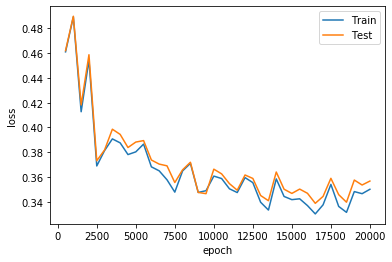

In [12]:
simple_clf = MulticlassPerceptron(n_classes, 20000, 82)
simple_clf.train(x_train, y_train, x_test, y_test, verbose=True)
simple_clf.plot_risks()
simple_clf.save_weights('simple-clf-weights.npy')

  500: train loss = 0.5053 | test loss = 0.5054
 1000: train loss = 0.4569 | test loss = 0.4612
 1500: train loss = 0.4178 | test loss = 0.4216
 2000: train loss = 0.3699 | test loss = 0.3732
 2500: train loss = 0.3858 | test loss = 0.3907
 3000: train loss = 0.3523 | test loss = 0.3571
 3500: train loss = 0.3850 | test loss = 0.3920
 4000: train loss = 0.3731 | test loss = 0.3822
 4500: train loss = 0.3634 | test loss = 0.3713
 5000: train loss = 0.3713 | test loss = 0.3761
 5500: train loss = 0.3614 | test loss = 0.3705
 6000: train loss = 0.3672 | test loss = 0.3673
 6500: train loss = 0.3392 | test loss = 0.3464
 7000: train loss = 0.3576 | test loss = 0.3611
 7500: train loss = 0.3480 | test loss = 0.3495
 8000: train loss = 0.3625 | test loss = 0.3656
 8500: train loss = 0.3678 | test loss = 0.3664
 9000: train loss = 0.3824 | test loss = 0.3863
 9500: train loss = 0.3572 | test loss = 0.3618
10000: train loss = 0.3399 | test loss = 0.3405
10500: train loss = 0.3427 | test loss =

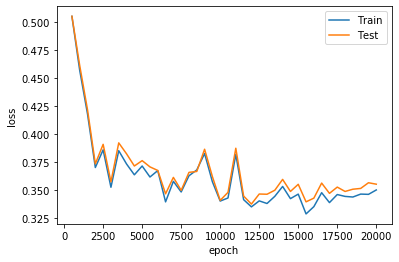

In [13]:
mira_clf = MulticlassPerceptron(n_classes, 20000, 82)
mira_clf.train(x_train, y_train, x_test, y_test, mira=True, verbose=True)
mira_clf.plot_risks()
simple_clf.save_weights('mira-clf-weights.npy')

# Kernelized Perceptron

In [17]:
class KernelizedPerceptron:
    def __init__(self, n_classes, n_epochs, input_dim, n_training_data):
        self.n_classes = n_classes
        self.n_epochs = n_epochs
        self.input_dim = input_dim
        self.n_training_data = n_training_data
        self.alphas = np.array([np.zeros(n_training_data) for _ in range(n_classes)])
        self.test_risks = []
        self.train_risks = []

    def predict(self, x):
        scores = [0] * self.n_classes
        for label in range(self.n_classes):
            for sample_number in range(self.n_training_data):
                if self.alphas[label][sample_number] == 0:
                    continue
                scores[label] += self.alphas[label][sample_number] * \
                    self.rbf(x, self.x_train[sample_number])
        return np.argmax(scores)

    def rbf(self, x, x_prime):
        return np.exp(-1 * (np.linalg.norm(x - x_prime) ** 2))

    def loss(self, samples, labels):
        wrongs = 0
        for x_sample, y_sample in zip(samples, labels):
            prediction = self.predict(x_sample)
            if y_sample != prediction:
                wrongs += 1
        return wrongs / samples.shape[0]

    def train(self, x_train, y_train, x_test, y_test, mira=False, verbose=False):
        self.x_train = x_train
        self.test_risks = []
        self.train_risks = []
        for epoch in range(1, self.n_epochs+1):
            # Find the wrong sample
            for sample_number, sample in enumerate(zip(x_train, y_train)):
                x_sample, y_sample = sample
                prediction = self.predict(x_sample)
                if y_sample != prediction:  # Is this sample predeicted wrongly?
                    # Learn!
                    self.alphas[y_sample][sample_number] += 1
                    self.alphas[prediction][sample_number] -= 1
                    break
                # All samples classified correctly. Time to return!
            if epoch % 500 == 0:
                test_risk = self.loss(x_test, y_test)
                train_risk = self.loss(x_train, y_train)
                self.test_risks.append((epoch, test_risk))
                self.train_risks.append((epoch, train_risk))
                if verbose:
                    print(
                        "{:5d}: train loss = {:.4f} | test loss = {:.4f}".format(epoch, train_risk, test_risk))
        return

    def plot_risks(self):
        x, y = zip(*self.train_risks)
        plt.plot(x, y, label='Train')
        x, y = zip(*self.test_risks)
        plt.plot(x, y, label='Test')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()

    def save_alphas(self, output_file_name):
        np.save(output_file_name, self.alphas)

    def load_alphas(self, file_name):
        self.alphas = np.load(file_name)

In [ ]:
# Warning: This cell takes a lot of time to execute.
kernelized_clf = KernelizedPerceptron(n_classes, 1000, 82, x_train.shape[0])
kernelized_clf.train(x_train, y_train, x_test, y_test, verbose=True)
kernelized_clf.plot_risks()
kernelized_clf.save_alphas('kernelized-clf-alphas.npy')

In [27]:
kernelized_clf = KernelizedPerceptron(n_classes, 1, 82, x_train.shape[0])
kernelized_clf.load_alphas('temp-clf-alphas.npy')
kernelized_clf.train(x_train, y_train, x_test, y_test, verbose=True)
kernelized_clf.loss(x_test, y_test)

0.286

# New Features

In [40]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import skimage.measure

model = VGG16(weights='imagenet', include_top=False)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [41]:
# Another feature extractor
def extract_features(image):
    # Resize (224, 224)
    image = cv.resize(image, (224, 224))
    # Colorize
    image = cv.cvtColor(image, cv.COLOR_GRAY2RGB)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    # Extract features => (7, 7, 512)
    features = model.predict(image)
    features = features.squeeze()
    # Average pooling
    features = skimage.measure.block_reduce(features, (7, 7, 4), np.mean)
    features = features.squeeze()
    return features

In [42]:
extract_features(x_train[0]).shape

(128,)

In [ ]:
# This cell takes a century to finish.
# We will save the extracted features to a file.
new_x_train = np.array([extract_features(image) for image in x_train])
new_x_test = np.array([extract_features(image) for image in x_test])
np.save('new_x_train', new_x_train)
np.save('new_x_test', new_x_test)